In [1]:
from bing_image_downloader import downloader

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras.optimizers import Adam
import tensorflow
from tensorflow import keras
from keras import models, layers
from tensorflow.keras import Sequential
from keras.models import Model
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization


In [2]:
from pathlib import Path
import imghdr

# Check image format

data_dir = "train images/jack russell"
image_extensions = [".bmp", ".gif", ".jpeg", ".png", ".webp", ".JPG"]

img_type_accepted_by_tf = [".jpg"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


In [3]:
# Check image format

data_dir = "train images/other dog"
image_extensions = [".bmp", ".gif", ".jpeg", ".png", ".webp", ".JPG"] 

img_type_accepted_by_tf = [".jpg"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


In [4]:
# Create training and validation datasets with ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    validation_split = 0.2

)

train_images = datagen.flow_from_directory(
    'images',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = datagen.flow_from_directory(
    'images',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 430 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [5]:
# Define labels

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'jack-russell', 1: 'other-dog'}

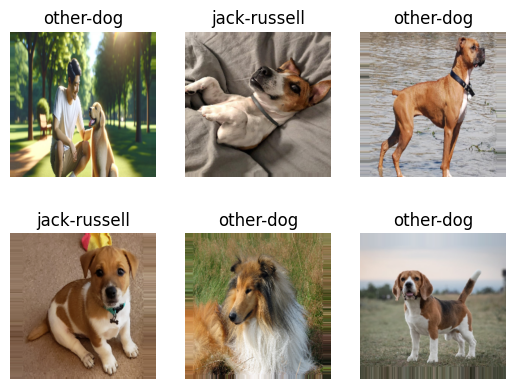

In [6]:
# Visualize a few samples from training dataset

fig, axes = plt.subplots(2, 3)
axes = axes.flatten()  

for i in range(6):
    plt.sca(axes[i])
    img, label = train_images.next()
    plt.imshow(img[0])
    plt.title(labels[label[0][1].item()])
    plt.axis ('off')
plt.show()

In [7]:
# Build the Incpetion V3 model architecture

def InceptionV3():
    input_layer = Input(shape=(299 , 299 , 3))
    
    x = StemBlock(input_layer)
    
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    
    x = ReductionBlock_A(prev_layer = x )
    
    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)
    
    
    x = ReductionBlock_B(prev_layer = x)
    
    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.4) (x)
    x = Dense(units=2, activation='softmax') (x)
    
    model = Model(inputs = input_layer , outputs = x, name = 'Inception-V3')
    
    return model


def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x


def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    return x    
    

def InceptionBlock_A(prev_layer  , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))
    
    output =  keras.layers.concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
    
    return output


def InceptionBlock_B(prev_layer , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))    
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    
    output =  keras.layers.concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output    

    
def InceptionBlock_C(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))    
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 =  keras.layers.concatenate([branch1_1 , branch1_2], axis = 3)
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 =  keras.layers.concatenate([branch2_1 , branch2_2], axis = 3)
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))
    
    output =  keras.layers.concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output


def ReductionBlock_A(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )
    
    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
    
    output =  keras.layers.concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output


def ReductionBlock_B(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
    
    output =  keras.layers.concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

In [8]:
model = InceptionV3()
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)
model.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_7 (BatchNo  (None, 36, 36, 96)  384         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 36, 36, 64)  256         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 36, 36, 32)  128         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 36, 36, 64)  256         ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_19 (BatchN  (None, 36, 36, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 36, 36, 64)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 36, 36, 96)   55392       ['activation_19[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 36, 36, 48)   13872       ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 18, 18, 288)  0          ['concatenate_2[0][0]']          
                                                                                                  
 concatenate_3 (Concatenate)    (None, 18, 18, 768)  0           ['activation_28[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_30 (Conv2D)             (None, 18, 18, 128)  98432       ['concatenate_3[0][0]']          
                                                                                                  
 batch_normalization_30 (BatchN  (None, 18, 18, 128)  512        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_40 (Conv2D)             (None, 18, 18, 160)  123040      ['concatenate_4[0][0]']          
                                                                                                  
 batch_normalization_40 (BatchN  (None, 18, 18, 160)  640        ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_40 (Activation)     (None, 18, 18, 160)  0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 18, 18, 160)  179360      ['activation_40[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_50 (Activation)     (None, 18, 18, 160)  0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 18, 18, 160)  179360      ['activation_50[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 18, 18, 160)  640        ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 18, 18, 160)  0           ['batch_normalization_51[0][0]'] 
          

                                                                                                  
 batch_normalization_61 (BatchN  (None, 18, 18, 192)  768        ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 18, 18, 192)  0           ['batch_normalization_61[0][0]'] 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 18, 18, 192)  258240      ['activation_61[0][0]']          
                                                                                                  
 conv2d_65 (Conv2D)             (None, 18, 18, 192)  147648      ['concatenate_6[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_72 (Conv2D)             (None, 18, 18, 192)  258240      ['activation_71[0][0]']          
                                                                                                  
 conv2d_74 (Conv2D)             (None, 18, 18, 192)  147648      ['concatenate_7[0][0]']          
                                                                                                  
 batch_normalization_72 (BatchN  (None, 18, 18, 192)  768        ['conv2d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 18, 18, 192)  768        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_81 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 batch_normalization_83 (BatchN  (None, 8, 8, 192)   768         ['conv2d_83[0][0]']              
 ormalization)                                                                                    
          

 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 batch_normalization_92 (BatchN  (None, 8, 8, 192)   768         ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 320)   1280        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 concatenate_12 (Concatenate)   (None, 8, 8, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
          

In [9]:
# Train the model

history = model.fit(
    train_images,
    epochs = 30,
    batch_size = 8,
    validation_data = val_images
)

Epoch 1/30


2024-06-07 15:35:22.337790: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


54/54 [==============================] - 31s 420ms/step - loss: 1.0224 - accuracy: 0.5698 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/30
54/54 [==============================] - 17s 309ms/step - loss: 0.7872 - accuracy: 0.6535 - val_loss: 1.0525 - val_accuracy: 0.5000
Epoch 3/30
54/54 [==============================] - 18s 338ms/step - loss: 0.7783 - accuracy: 0.6488 - val_loss: 0.7580 - val_accuracy: 0.5000
Epoch 4/30
54/54 [==============================] - 17s 310ms/step - loss: 0.7060 - accuracy: 0.7116 - val_loss: 0.7978 - val_accuracy: 0.5000
Epoch 5/30
54/54 [==============================] - 17s 312ms/step - loss: 0.6010 - accuracy: 0.7279 - val_loss: 0.9276 - val_accuracy: 0.5000
Epoch 6/30
54/54 [==============================] - 18s 332ms/step - loss: 0.5873 - accuracy: 0.7419 - val_loss: 0.7569 - val_accuracy: 0.5094
Epoch 7/30
54/54 [==============================] - 17s 319ms/step - loss: 0.5137 - accuracy: 0.7558 - val_loss: 0.8857 - val_accuracy: 0.5000
Epoch 8/30

In [10]:
# Show metrics

train_acc, train_loss = model.evaluate(train_images, verbose=0)
val_acc, val_loss = model.evaluate(val_images, verbose=0)
print("    Train Loss: {:.5f}".format(train_acc))
print("Train Accuracy: {:.2f}%".format(train_loss * 100))
print("    Valid Loss: {:.5f}".format(val_acc))
print("Valid Accuracy: {:.2f}%".format(val_loss * 100))

    Train Loss: 0.23356
Train Accuracy: 92.79%
    Valid Loss: 1.47848
Valid Accuracy: 65.09%


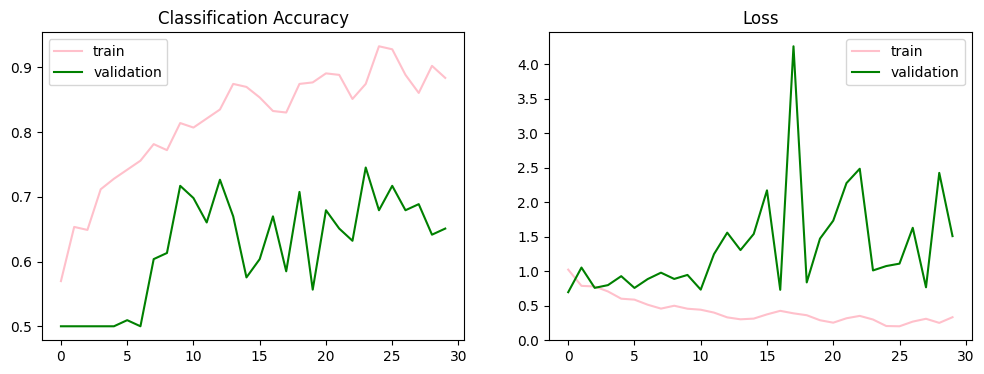

In [11]:
# Show model perfomance

fig, (accuracy, loss) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 4)
accuracy.title.set_text('Classification Accuracy')
accuracy.plot(history.history['accuracy'], color='pink', label='train')
accuracy.plot(history.history['val_accuracy'], color='green', label='validation')
accuracy.legend(['train', 'validation'])
loss.title.set_text('Loss')
loss.plot(history.history['loss'], color='pink', label='train')
loss.plot(history.history['val_loss'], color='green', label='validation')
loss.legend(['train', 'validation'])
plt.show()

In [12]:
from keras.models import load_model

# Save the final model

model.save('./inceptionV3.h5')  

In [22]:
class_names = ['other dog', 'jack russell']

1/1 [==============================] - 0s 117ms/step
2.46% 	 jack russell
97.54% 	 other dog


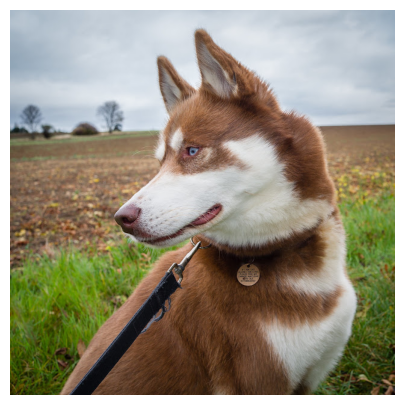

In [23]:
# Predict the test image

image = Image.open('test_images/Image_6.jpg')
image_resized = image.convert('RGB').resize((299, 299))
image_array = np.array(image_resized) / 255.0
predicted_value = model.predict(image_array.reshape(1, 299, 299, 3))

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
for idx in predicted_value.argsort()[0]:
    print("{:.2f}%".format(predicted_value[0][idx]*100), "\t", class_names[idx])
